In [2]:
import numpy as np
import midi_manipulation
import matplotlib.pyplot as plt
import tensorflow as tf
import midi
#from midi2audio import FluidSynth
import pretty_midi
from midi2pianoroll import midi_to_pianorolls
from pianoroll2midi import get_midi

%matplotlib inline
from IPython.display import Audio, display

checkpoint_file = './checkpoints/vae_gruntyslair_onecnn_iter2000.ckpt'

/home/eko/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm


In [6]:
# from music21 import *

# b = converter.parse('../audio_files/01.mxl')
# bChords = b.chordify()


# # for thisChord in bChords.recurse().getElementsByClass('Chord'):
# #     if thisChord.:
# #         print thisChord

In [3]:
# instrument change/selection
from music21 import converter,instrument # or import *
s = converter.parse('../audio_files/midi_input/banjo_kazooie_gruntildas_lair.mid')

for el in s.recurse():
    if 'Instrument' in el.classes: # or 'Piano'
        el.activeSite.replace(el, instrument.Violin()) # get only violin sounds

s.write('midi', 'newfilename1.mid')

'newfilename1.mid'

In [ ]:
# still working with this cell for manually extracting chord information

# pattern = midi.read_midifile('newfilename1.mid')
# melody = midi.Track()
# current = None
# for event in in pattern[0]:
#     # note: I'm assuming that everything is on the first track
#     if isinstance(event, midi.NoteOnEvent):
#         if current is None:
#             # no note is playing, we suppose it *might* be the melody
#             melody.append(event)
#             current = event
#         elif event.pitch > current.pitch:
#             # we have a new higher note, so we stop the previous one and start the new one
#             melody.append(midi.NoteOffEvent(tick=event.tick - 1, channel=current.channel, data=current.data))
#             melody.append(event)
#             current = None
#     elif isinstance(event, midi.NoteOffEvent) and current is not None and event.pitch == current.pitch:
#         melody.append(event)
#         current = None
# melody.append(midi.EndOfTrackEvent(tick=event.tick)
# melody_pattern = midi.Pattern()
# melody_pattern.append(melody)
# midi.write_midifile('melody.mid', melody_pattern)

In [ ]:
# todo
# time step note level
# midi file bar level


In [6]:
with open('newfilename1.mid', 'rb') as f:
    song = np.array(midi_manipulation.midiToNoteStateMatrix(f))

## Load the song

In [4]:
pm = pretty_midi.PrettyMIDI('../audio_files/midi_input/banjo_kazooie_gruntildas_lair.mid')
initial_tempo = pm.get_tempo_changes()[1][0]
fs = (initial_tempo / 60) * 8
piano_roll = pm.get_piano_roll(fs=fs)
piano_roll = (piano_roll.T > 0).astype(np.float32)

/home/eko/anaconda2/lib/python2.7/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


In [5]:
pm = piano_roll_to_pretty_midi(piano_roll.T*127, fs)
pm.write('../audio_files/output/pm_test.mid')

In [6]:
num_timesteps = int(fs)
note_range = 128
T = 16
num_batches = int(piano_roll.shape[0] // (fs * T))
height = num_timesteps
width = note_range
n_visible = note_range * num_timesteps
n_hidden = 512

num_epochs = 2000

z_dim = 256
X_dim = width * height
h_dim = n_hidden

initializer = tf.contrib.layers.xavier_initializer()

## Helper functions/models

In [7]:
def gru(inputs, size=512, initial_state=None, name="gru", reuse=False, dtype=tf.float32):
    with tf.variable_scope(name, reuse=reuse) as scope:
        cell = tf.contrib.rnn.GRUCell(size, reuse=reuse)
        input_shape = tf.shape(inputs)

        if initial_state is None:
            initial_state = cell.zero_state(batch_size=input_shape[0], dtype=dtype)

        outputs,state = tf.nn.dynamic_rnn(cell, inputs, 
                            initial_state=initial_state, dtype=dtype)
        return outputs, state
    
def conv_relu_pool(inputs, kernel_shape, pool_shape, name="conv2d", reuse=False, dtype=tf.float32):
    with tf.variable_scope(name) as scope:
        conv_kernel = tf.get_variable('conv2d', shape=kernel_shape, initializer=initializer, dtype=dtype)
        conv_bias = tf.get_variable('conv2d_b', shape=kernel_shape[3], dtype=dtype)
        
        conv = tf.nn.conv2d(inputs, conv_kernel, [1,1,1,1], "VALID")
        preact = tf.nn.bias_add(conv, conv_bias)
        relu = tf.nn.relu(preact)
        pool = tf.nn.max_pool(relu, pool_shape, pool_shape, "VALID")

        return pool

In [8]:
z = tf.placeholder(tf.float32, shape=[None, z_dim], name="Generated_noise")
z_rnn_samples = tf.placeholder(tf.float32, shape=[None, height, width, 1], name="Generated_midi_input")

X = tf.placeholder(tf.float32, shape=[None, height, width, 1], name="Training_samples")

kl_annealing = tf.placeholder(tf.float32, name="KL_annealing_multiplier")

f_dim = 19584

def midi_latent_feature(X, keep_prob=1.0, name='latent_feauture', reuse=False):
    with tf.variable_scope(name, reuse=reuse) as scope:
        conv1_out = conv_relu_pool(X, 
                                   kernel_shape=[2,2,1,32],
                                   pool_shape=[1, 2, 2, 1],
                                   name="conv_1")

        conv2_out = conv_relu_pool(conv1_out, 
                                   kernel_shape=[2, 2 , 32 , 32],
                                   pool_shape=[1, 2, 2, 1],
                                   name="conv_2")

        h = tf.contrib.layers.flatten(conv2_out)

        return tf.nn.dropout(h, keep_prob=keep_prob)

def Q(X, name_scope="Encoder", keep_prob=1.0):
    with tf.name_scope(name_scope):
        with tf.name_scope("Encoder_RNN"):
            #Expand dims for rnn to [1, T, k]
            rnn_in = tf.expand_dims(X, 0)
            rnn_outs, rnn_state = gru(rnn_in, size=z_dim, name="gru_enc")
            #Reshape
            rnn_state = tf.reshape(rnn_state[-1,:], [1, z_dim])
        
        with tf.name_scope("Calculate_mu_sigma"):
            Q_W2_mu = tf.get_variable('encoder_mean_weights', shape=[z_dim, z_dim], initializer=initializer)
            Q_b2_mu = tf.get_variable('encoder_mean_bias', shape=[z_dim], initializer=initializer)

            Q_W2_sigma = tf.get_variable('encoder_variance_weights', shape=[z_dim, z_dim], initializer=initializer)
            Q_b2_sigma = tf.get_variable('encoder_variance_bias', shape=[z_dim], initializer=initializer)
            #KL divergence with last GRU state
            z_mu = tf.matmul(rnn_state, Q_W2_mu) + Q_b2_mu
            z_logvar = tf.matmul(rnn_state, Q_W2_sigma) + Q_b2_sigma
        return z_mu, z_logvar

def sample_z(mu, log_var):
    with tf.name_scope("Random_samples"):
        eps = tf.random_normal(shape=tf.shape(mu))
        return mu + tf.exp(log_var / 2) * eps

In [9]:
def P(z, name_scope="Decoder", xt=None, keep_prob=1.0, reuse=False):
    with tf.name_scope(name_scope):
        with tf.name_scope("concatenate_noise_and_input"):
            #Expand dims for RNN
            if xt is not None:
                #Used to transform CNN representation
                P_W1 = tf.get_variable('P_W1', shape=[xt.get_shape().as_list()[1], z_dim], initializer=initializer)
                P_b1 = tf.get_variable('P_b1', shape=[z_dim], initializer=initializer)
                xt_in = tf.matmul(xt, P_W1) + P_b1
                z = tf.concat([z, xt_in], axis=0)
            z = tf.expand_dims(z, 0)

        with tf.name_scope("Decoder_RNN"):
            dec_outs, _ = gru(z, size=h_dim, name="gru_dec", reuse=reuse)
            dec_outs = tf.reshape(dec_outs, [-1, h_dim])

            drop = tf.nn.dropout(dec_outs, keep_prob=keep_prob)

            P_W2 = tf.get_variable('P_W2', shape=[h_dim, X_dim], initializer=initializer)
            P_b2 = tf.get_variable('P_b2', shape=[X_dim], initializer=initializer)

        logits = tf.matmul(drop, P_W2) + P_b2
        prob = tf.nn.sigmoid(logits)
        return prob, logits

## VAE-RNN model

In [10]:
with tf.variable_scope('vae_rnn') as scope:
    
    latent_feature_enc = midi_latent_feature(X, name='CNN_Encoder')
    #latent_feature_dec = midi_latent_feature(X, name='cnn_dec')

    z_mu, z_logvar = Q(latent_feature_enc, name_scope="Encoder_train")
    z_sample = sample_z(z_mu, z_logvar)

    out_samples, logits = P(z_sample, name_scope="Decoder_train", xt=latent_feature_enc[:-1])

    # Sampling from random z
    scope.reuse_variables()
    latent_z_rnn = midi_latent_feature(z_rnn_samples, name='CNN_Encoder', reuse=True)
    X_samples, _ = P(z, name_scope="Decoder_test", xt=latent_z_rnn, reuse=True)

with tf.name_scope("Loss"):
    X_labels = tf.reshape(X, [-1, width*height])

    with tf.name_scope("cross_entropy"):
        recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X_labels), 1)
    with tf.name_scope("kl_divergence"):
        kl_loss = kl_annealing * 0.5 * tf.reduce_sum(tf.square(z_mu) + tf.square(z_logvar) - tf.log(tf.square(z_logvar)) - 1,1) 
    
    loss = tf.reduce_mean(recon_loss + kl_loss)

with tf.name_scope("Optimizer"):
    solver = tf.train.AdamOptimizer()
    grads = solver.compute_gradients(loss)
    grads = [(tf.clip_by_norm(g, clip_norm=10), v) for g, v in grads]
    train_op = solver.apply_gradients(grads)

In [11]:
with tf.name_scope("Logging"):
    recon_loss_ph = tf.placeholder(tf.float32)
    kl_loss_ph = tf.placeholder(tf.float32)
    loss_ph = tf.placeholder(tf.float32)

    tf.summary.scalar("Reconstruction_loss", recon_loss_ph)
    tf.summary.scalar("KL_loss", kl_loss_ph)
    tf.summary.scalar("Loss", loss_ph)
    log_op = tf.summary.merge_all()

writer = tf.summary.FileWriter('./tf_logs/', graph=tf.get_default_graph(), audio=tf.)

In [12]:
def annealing_sched(epoch):
    return np.min([0.01*epoch, 1.])

In [36]:
audio = tf.Summary.Audio(encoded_audio_string='test',
                         content_type='audio/wav',
                         sample_rate=44100,
                         length_frames=22050)

event = tf.summary.Event(summary=tf.Summary(value=[tf.Summary.Value(audio=audio)]))
#writer.add_event(event)

('Iter: ', 0)
('Loss: ', 284.28119)
('KL Loss:', array([ 33.9565239], dtype=float32))
('Recon Loss', array([ 944.14868164,  450.55883789,  301.83151245,  254.85339355,
        264.03918457,  206.19580078,  170.73547363,  159.66281128,
        165.80084229,  151.44470215,  147.99087524,  167.39981079,
        164.16026306,  153.97561646,  159.17071533,  143.2260437 ], dtype=float32))
('Iter: ', 100)
('Loss: ', 75.655899)
('KL Loss:', array([ 3.51544929], dtype=float32))
('Recon Loss', array([ 145.56651306,  104.88929749,  111.00580597,  101.30203247,
        118.23716736,   97.32704926,   59.00013733,   53.45066452,
         53.30352402,   35.61365891,   35.92259216,   63.07056046,
         54.36038589,   42.20522308,   49.31981659,   29.67285156], dtype=float32))
('Iter: ', 200)
('Loss: ', 12.879093)
('KL Loss:', array([ 0.65393072], dtype=float32))
('Recon Loss', array([ 128.71286011,    9.92991257,    8.35079384,    9.90834427,
          6.81158352,    6.66662788,    3.07827687,    2

/home/eko/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


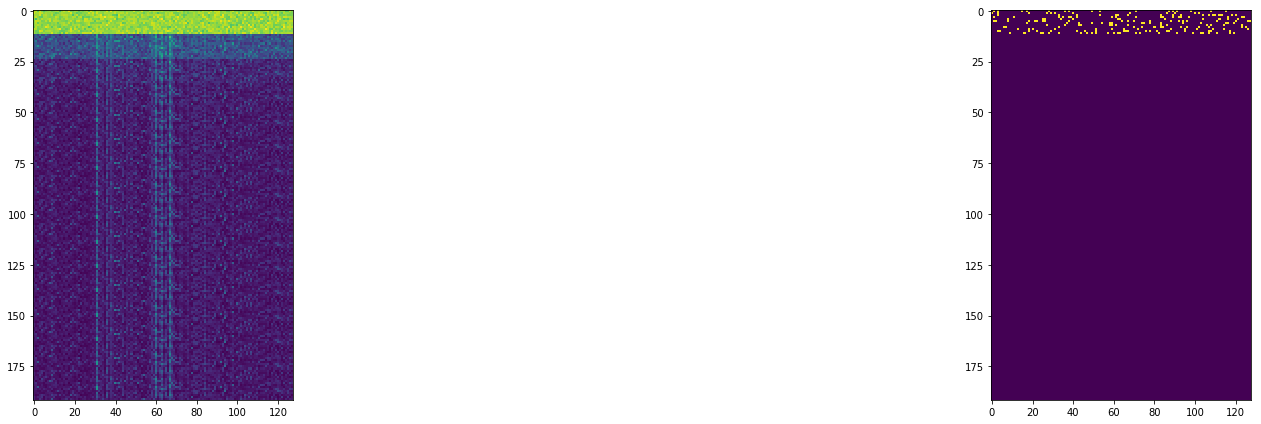

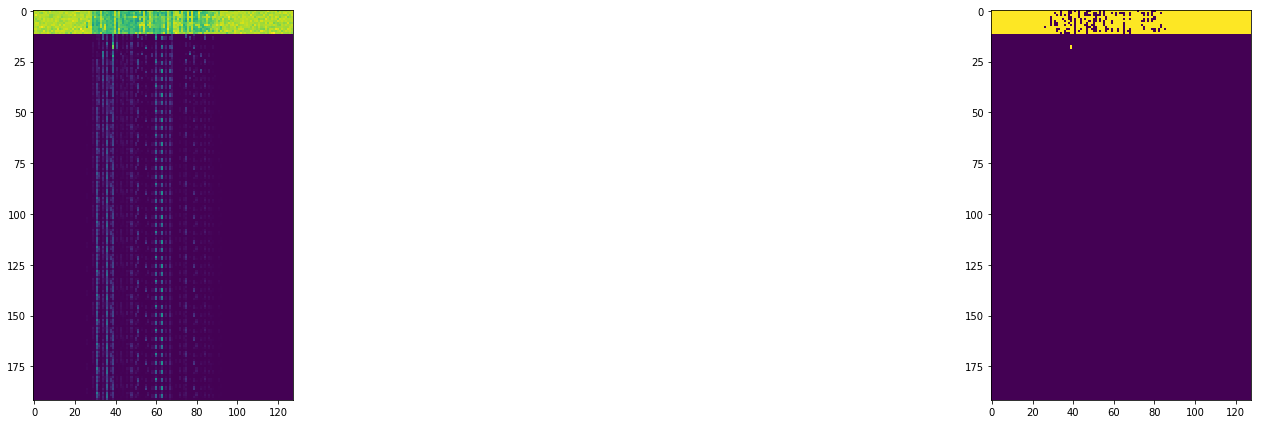

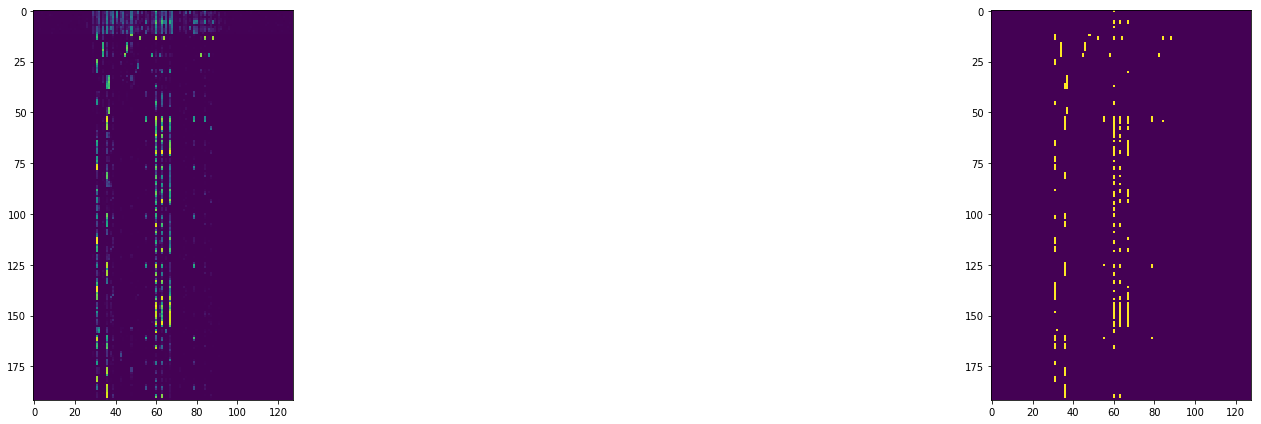

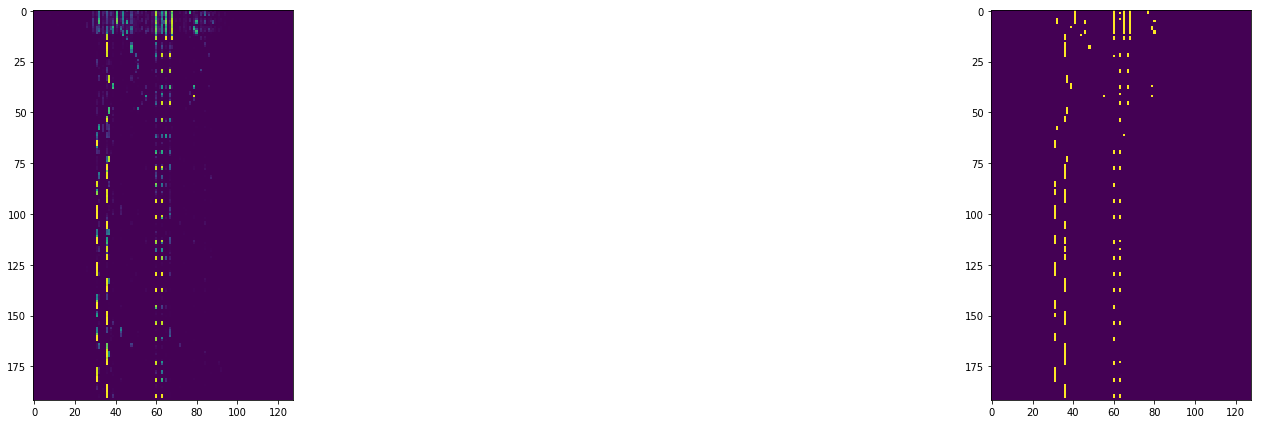

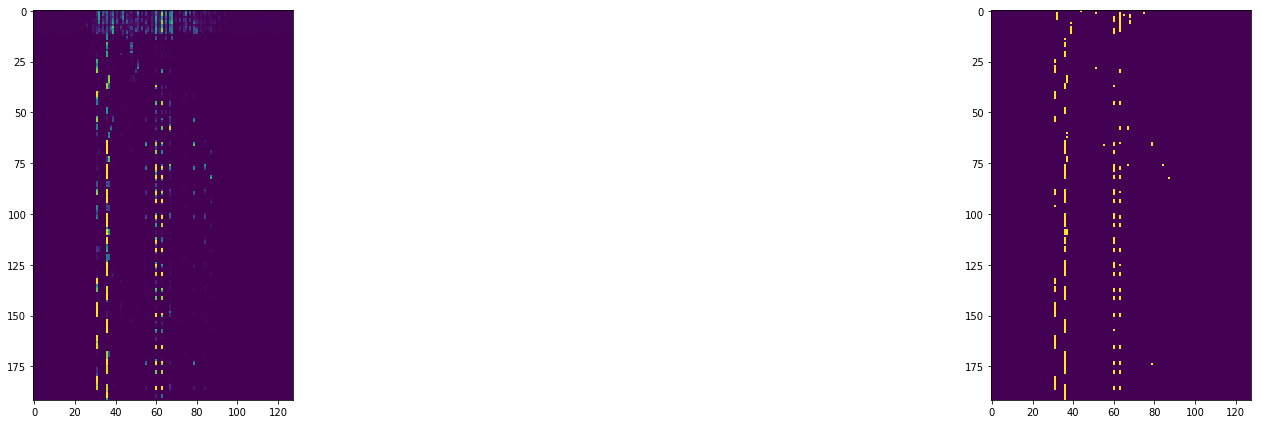

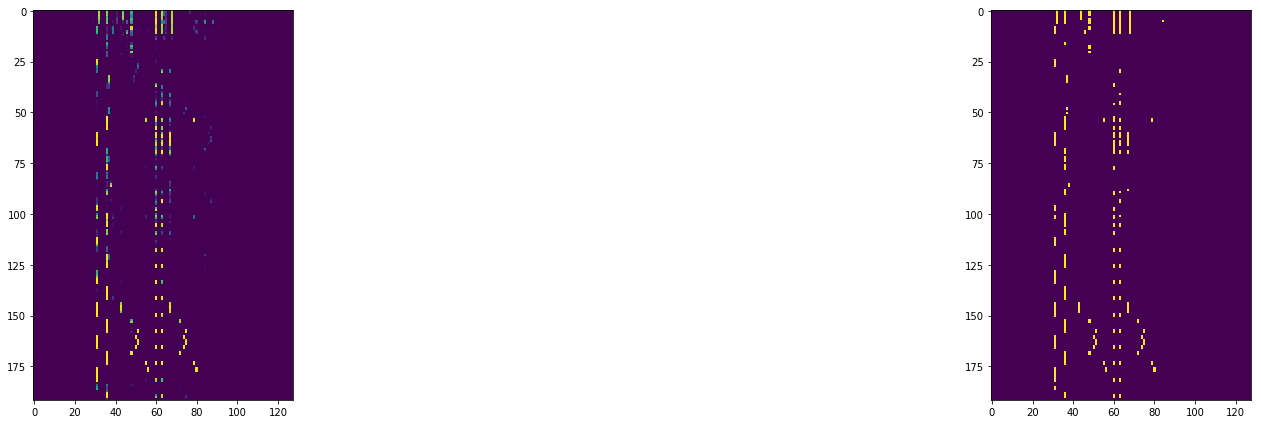

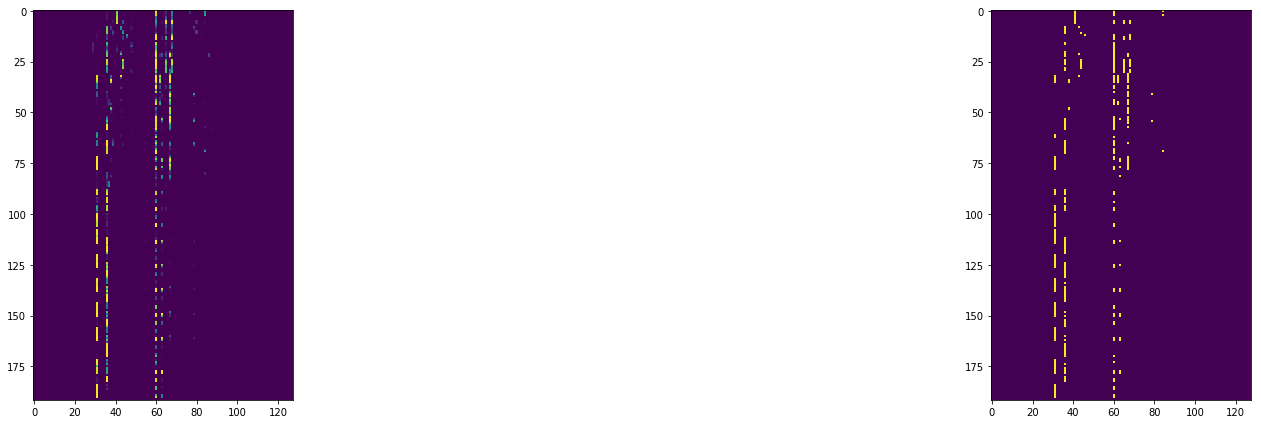

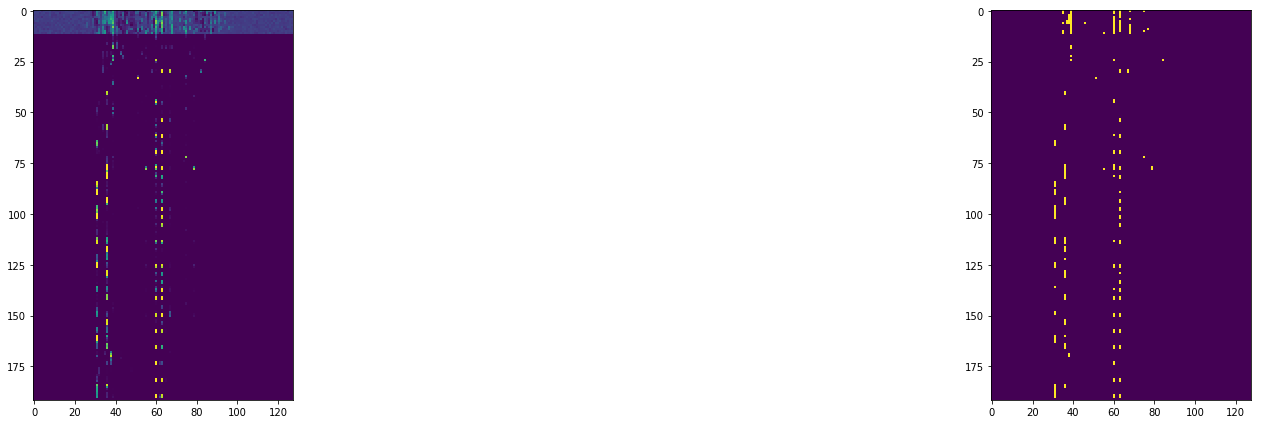

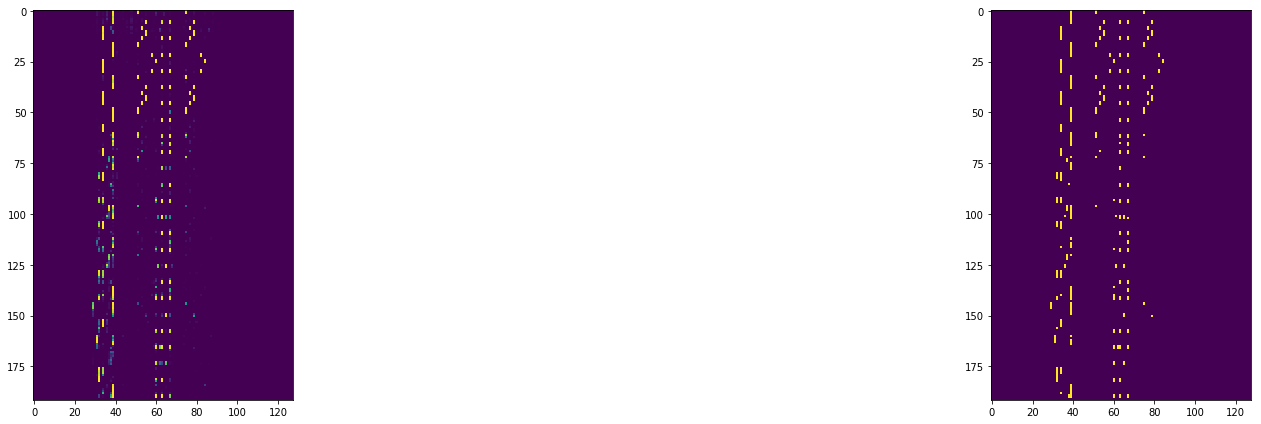

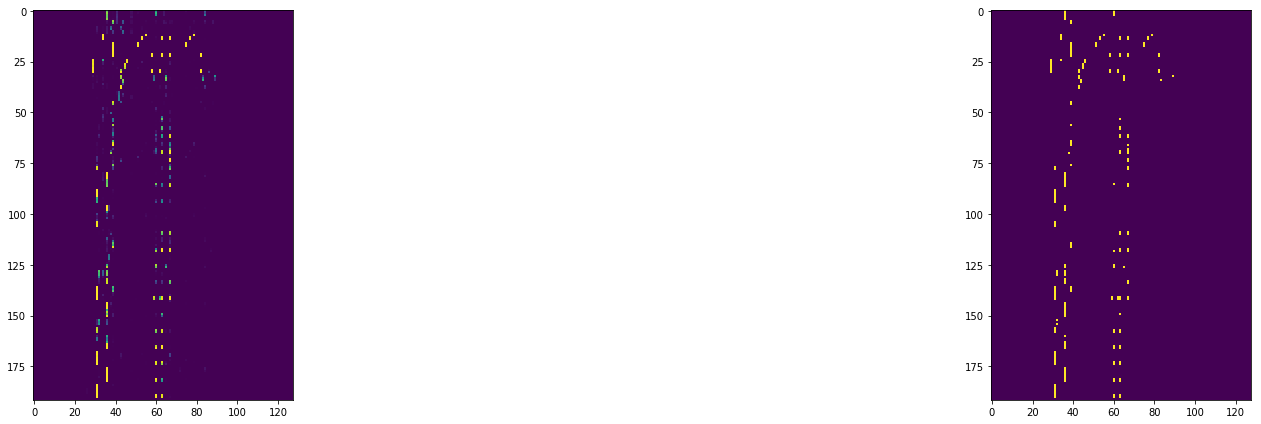

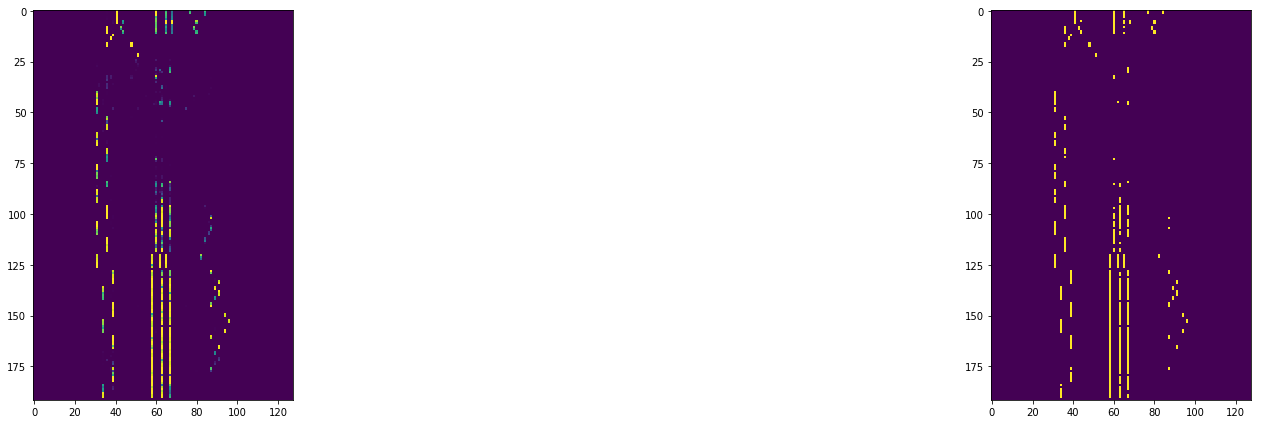

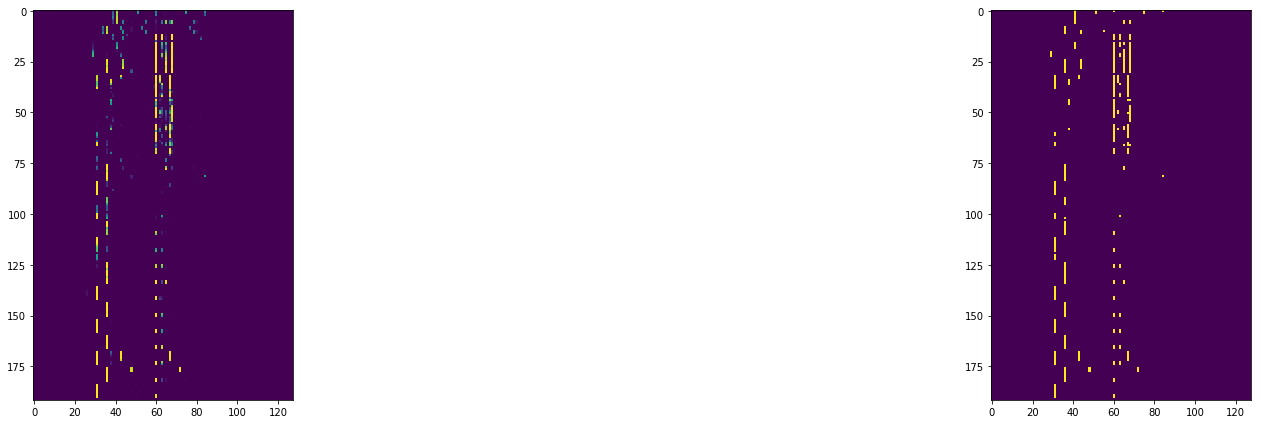

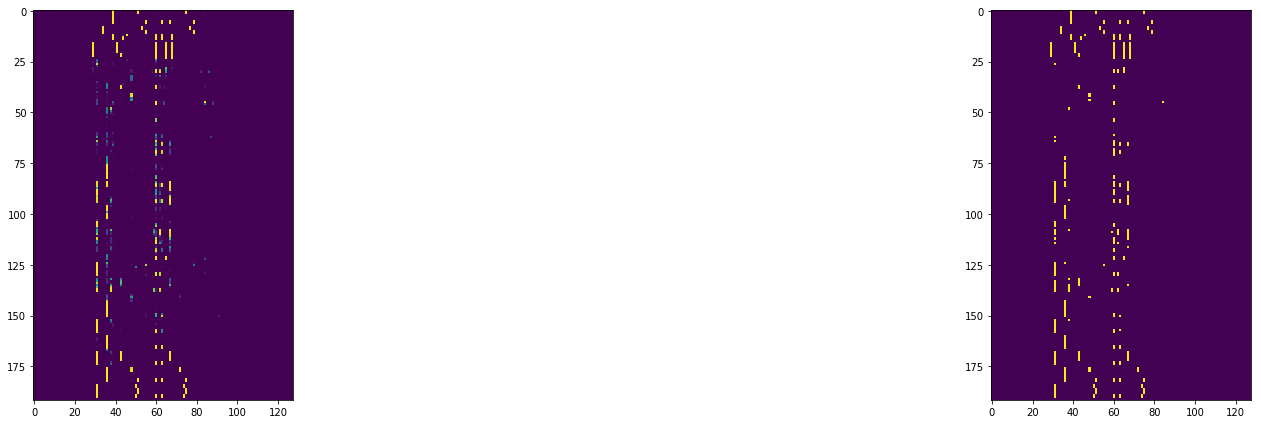

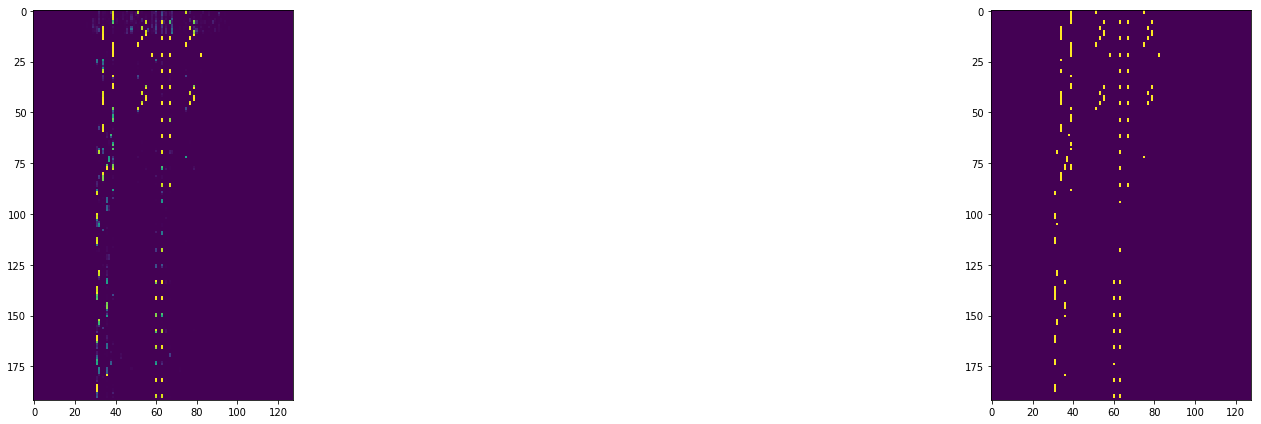

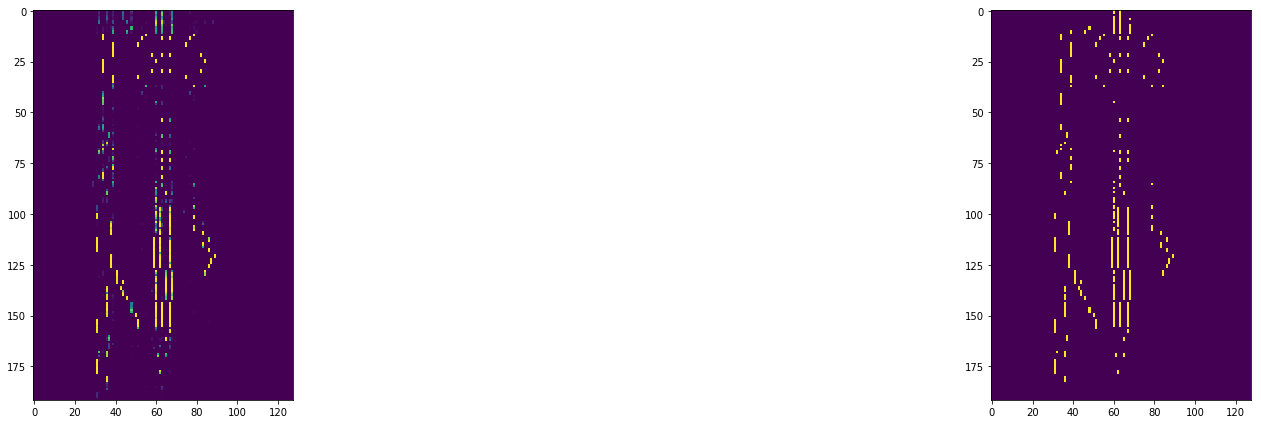

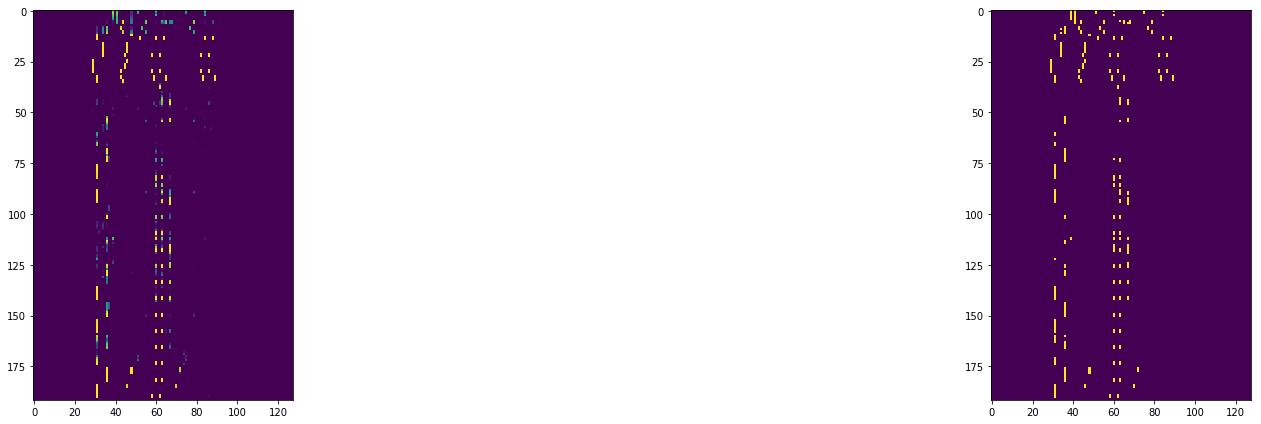

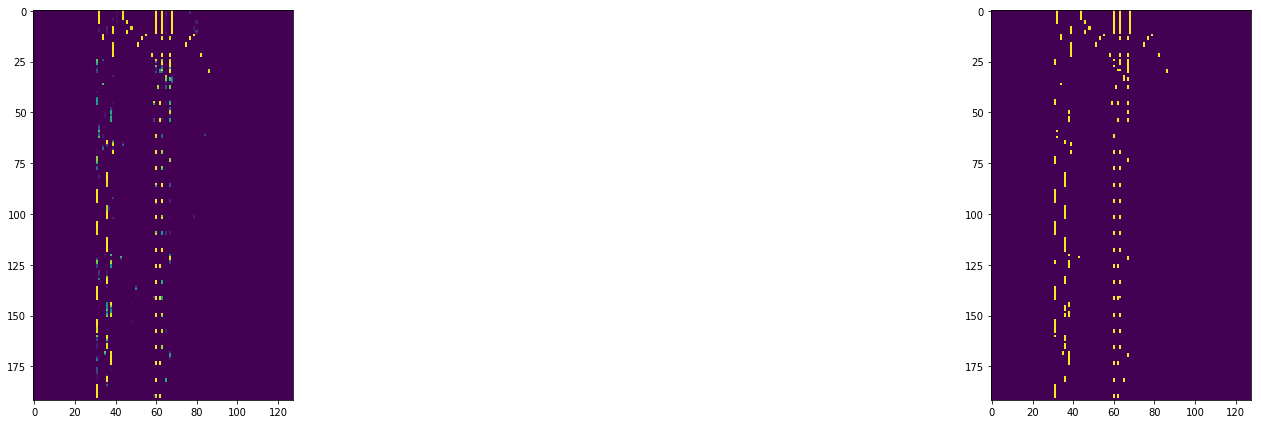

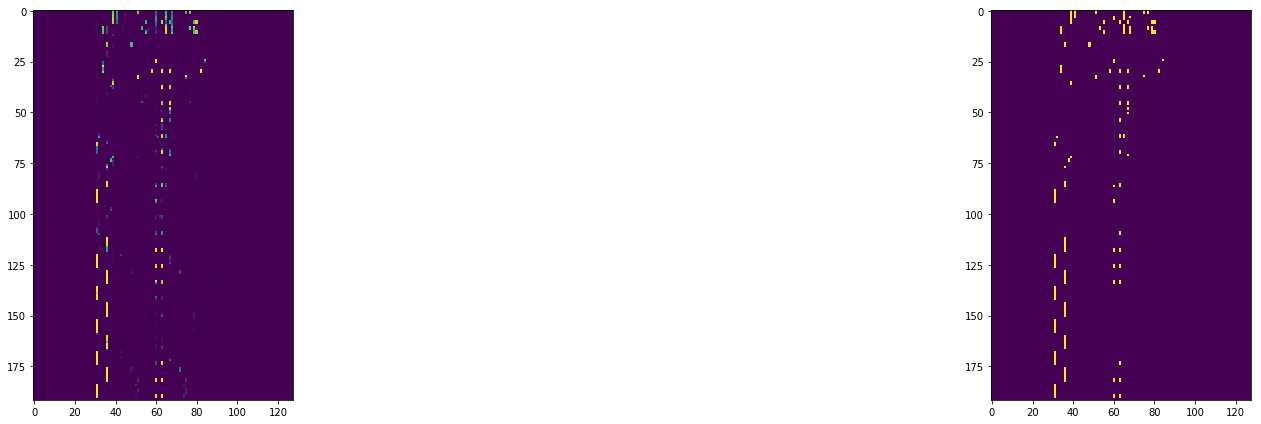

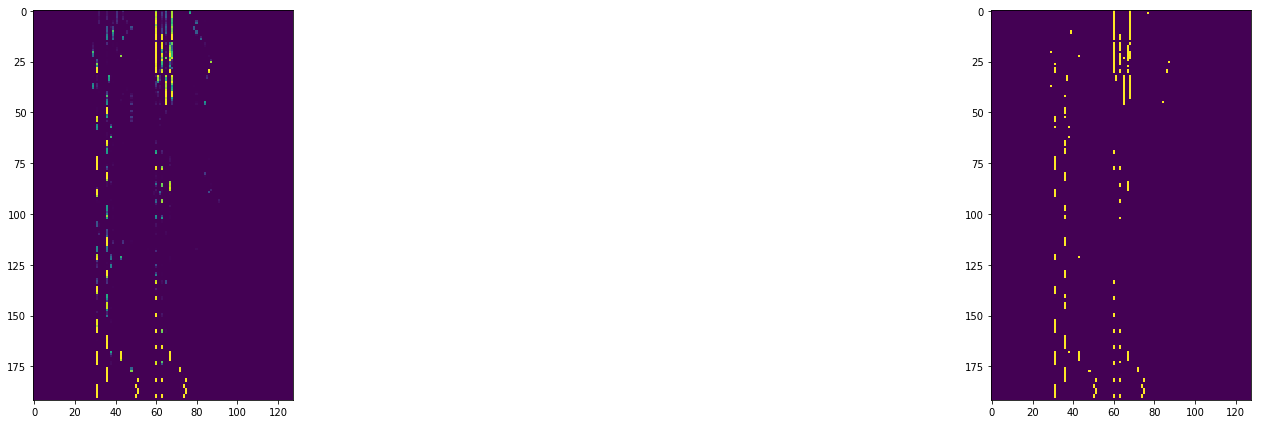

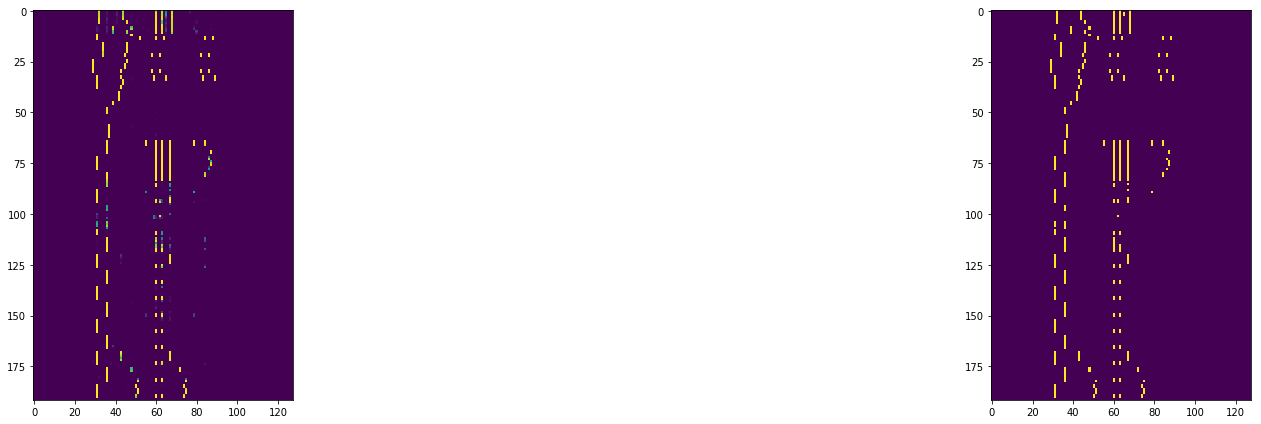

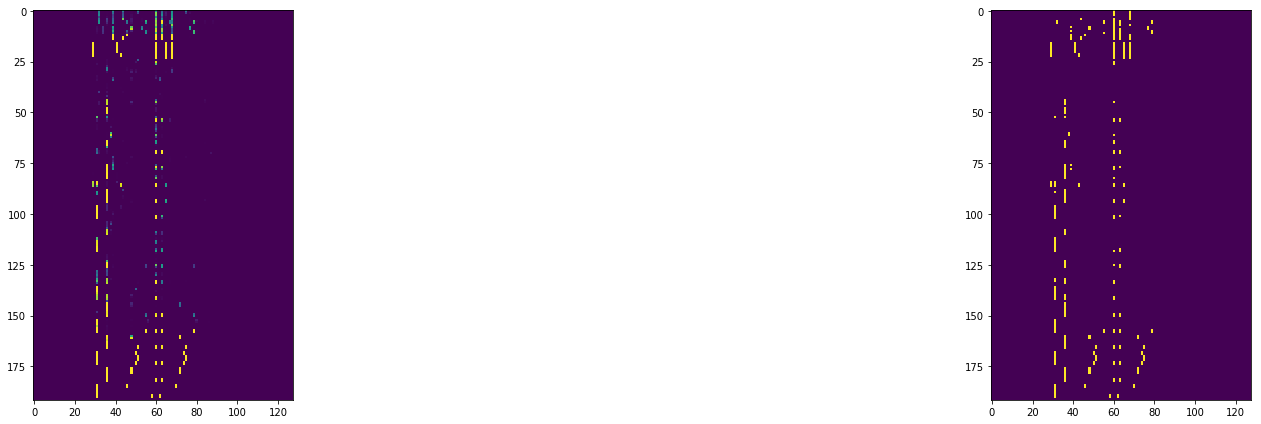

In [13]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    while i <= num_epochs:
        #s = song[20:20+num_timesteps,:].reshape(1,num_timesteps*2*note_range)
        for b in range(num_batches):
            s = piano_roll[b*T*num_timesteps:(b+1)*T*num_timesteps, :note_range].reshape(T, height, width, 1)
            kla = annealing_sched(i)
            #X_mb = song[(ind*num_timesteps):num_timesteps*(ind + 1), :].reshape(1, height, width, 1)
            _,loss_out, kl, recon = sess.run([train_op, loss, kl_loss, recon_loss], feed_dict={X: s, kl_annealing: 1.0})

        if i % 100 == 0:
            print('Iter: ', i)
            print('Loss: ', loss_out)
            print('KL Loss:', kl)
            print('Recon Loss', recon)

            #Random samples
            z_in = np.random.randn(1, z_dim)
            z_rnn_out = np.zeros((1,height,width,1))
            first = True
            for j in range(T):
                samples = sess.run(X_samples, feed_dict={z: np.random.randn(1, z_dim), z_rnn_samples: z_rnn_out})
                frames = j + 1
                if first:
                    frames = 2
                z_rnn_out = samples.reshape((frames, height, width, 1))
                if first:
                    z_rnn_out = np.expand_dims(z_rnn_out[-1,:,:,:], axis=0)
                    first = False
            samples = samples.reshape((num_timesteps*T, note_range))
            thresh_S = samples >= 0.5
            plt.figure(figsize=(36,6))
            plt.subplot(1,2,1)
            plt.imshow(samples)
            plt.subplot(1,2,2)
            plt.imshow(thresh_S)
            plt.tight_layout()
            plt.pause(0.1)
            
            #Write out logs
            summary = sess.run(log_op, feed_dict={recon_loss_ph: np.mean(recon), kl_loss_ph: np.mean(kl),
                                                 loss_ph: loss_out})
            writer.add_summary(summary, i)
            
            pm_out = piano_roll_to_pretty_midi(thresh_S.T * 127, fs=4)
            pm_out.write('../audio_files/output/test002_{0}.mid'.format(datetime.now().strftime("%Y.%m.%d.%H:%M:%S")))
        
        i += 1
        saver.save(sess, checkpoint_file)
    writer.add_event(event)

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, checkpoint_file)
    #Generate T frames
   
    #Random samples
    z_in = np.random.randn(1, z_dim)
    z_rnn_out = np.zeros((1,height,width,1))
    first = True
    for j in range(T*3):
        sams = sess.run(X_samples, feed_dict={z: np.random.randn(1, z_dim), z_rnn_samples: z_rnn_out})
        frames = j + 1
        if first:
            frames = 2
        z_rnn_out = sams.reshape((frames, height, width, 1))
        if first:
            z_rnn_out = np.expand_dims(z_rnn_out[-1,:,:,:], axis=0)
            first = False
    sams = sams.reshape((num_timesteps*T*3, note_range))
    thresh_S = (sams >= 0.5).astype(np.float32) * 127
    #thresh_S = sams >= 0.5
    
    ##pm_out = piano_roll_to_pretty_midi(thresh_S.T, fs=4)
    ##pm_out.write('../audio_files/output/test.mid')
    
    plt.figure(figsize=(36,6))
    plt.subplot(1,2,1)
    plt.imshow(sams)
    plt.subplot(1,2,2)
    plt.imshow(thresh_S)
    plt.tight_layout()
    plt.pause(0.1)
#     #song = np.concatenate((song, thresh_S), axis=0)
    #midi_manipulation.noteStateMatrixToMidi(np.pad(thresh_S, ((0,0), (0, 128)), mode='constant'), "../audio_files/output/test")
    pm = piano_roll_to_pretty_midi(thresh_S.T, fs)
    pm.write('../audio_files/output/test05.mid')
    writer.add_event(event)

In [15]:
thresh_S

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

## Plain RNN model

In [16]:
def rnn_logits(x, keep_prob=1.0):
    x = tf.expand_dims(x, 0)
    dec_outs, _ = gru(x, size=h_dim)
    dec_outs = tf.reshape(dec_outs, [-1, h_dim])

    drop = tf.nn.dropout(dec_outs, keep_prob=keep_prob)
    logits = tf.matmul(drop, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

In [17]:
with tf.variable_scope("rnn_model") as scope:
    latent_feature = midi_latent_feature(X)
    print(latent_feature)
    prob, logits = rnn_logits(latent_feature[:-1])
    print(logits)
    X_labels = tf.reshape(X[1:], [-1, width*height])
    print(X_labels)

    scope.reuse_variables()
    latent_z_rnn = midi_latent_feature(z_rnn_samples)
    samples,_ = rnn_logits(latent_z_rnn)

recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X_labels), 1)
loss = tf.reduce_mean(recon_loss)

solver = tf.train.AdamOptimizer().minimize(loss)

Tensor("rnn_model/latent_feauture/Flatten/flatten/Reshape:0", shape=(?, 1984), dtype=float32)


NameError: global name 'P_W2' is not defined

In [9]:
saver = tf.train.Saver()

('Iter: ', 0)
('Loss: ', 2165.1704)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


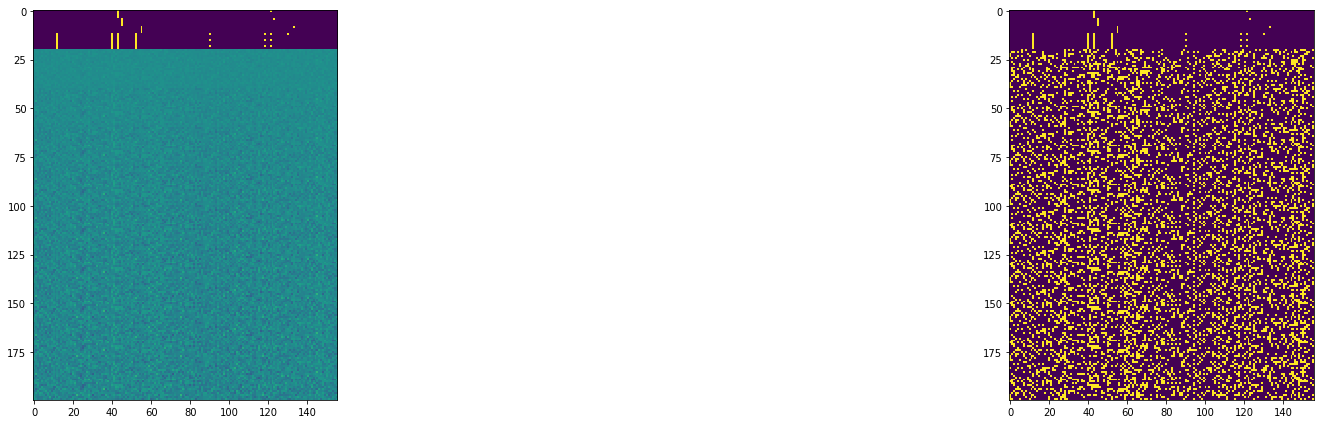

('Iter: ', 100)
('Loss: ', 206.98145)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


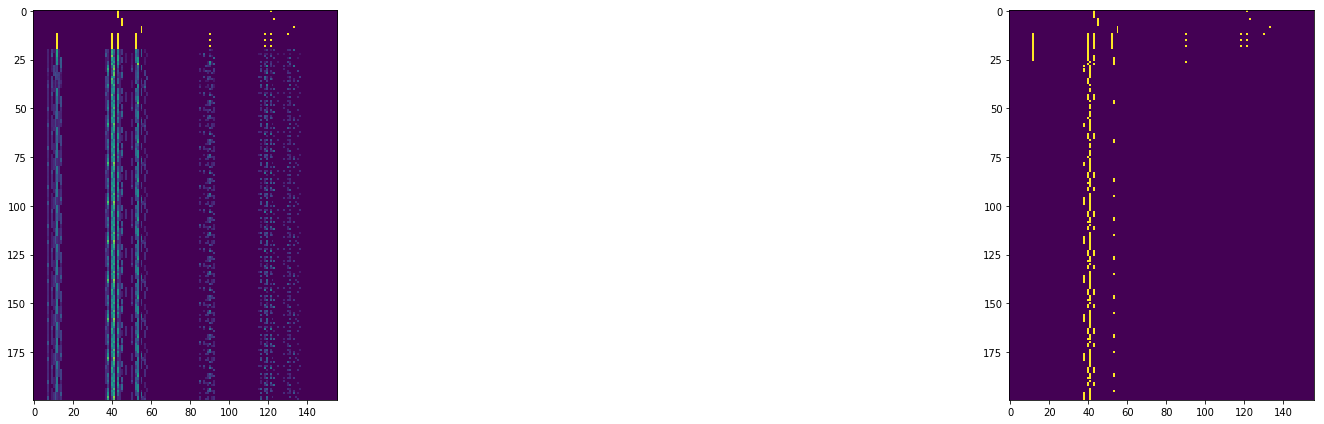

('Iter: ', 200)
('Loss: ', 147.95474)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


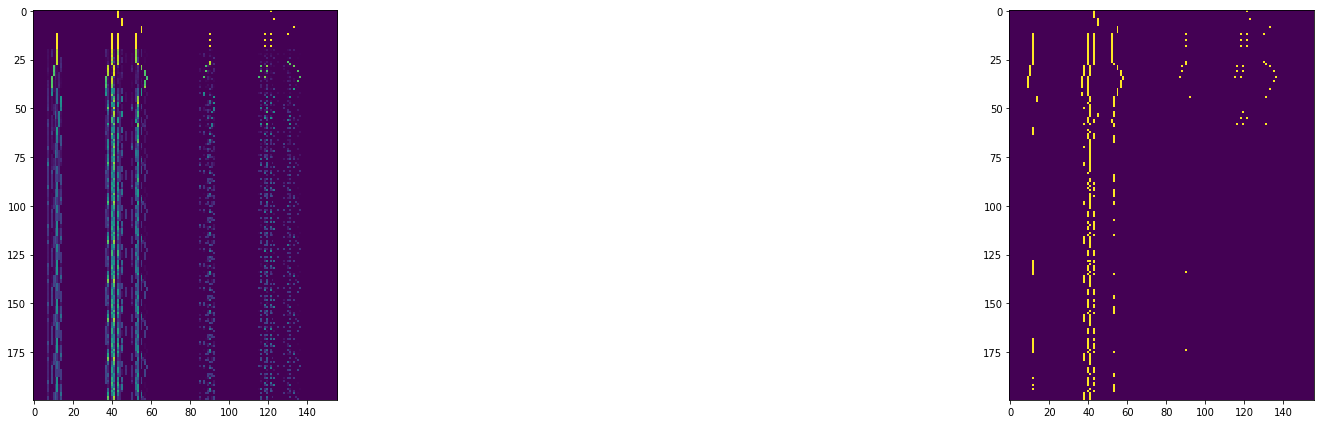

('Iter: ', 300)
('Loss: ', 120.50926)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


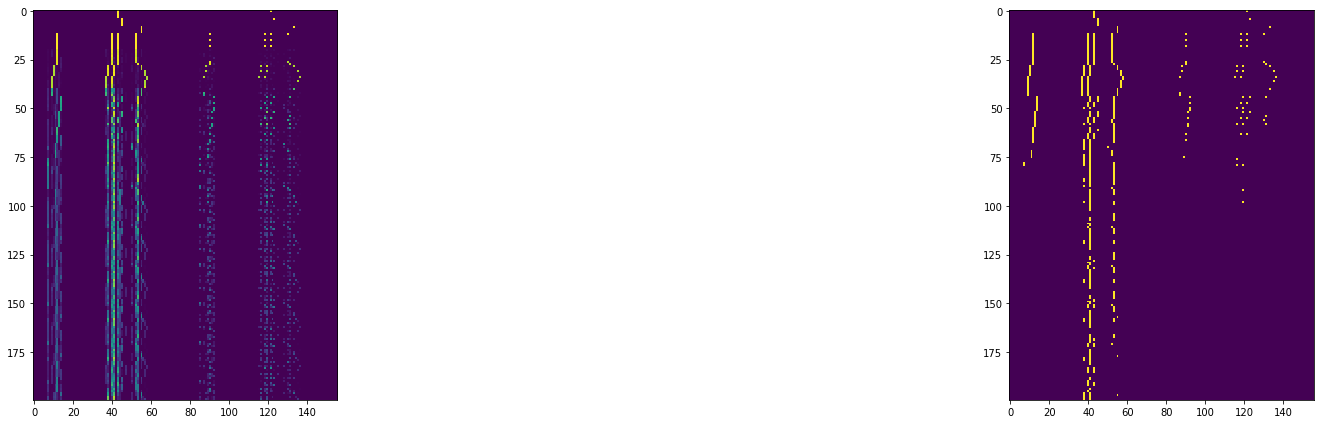

('Iter: ', 400)
('Loss: ', 100.31436)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


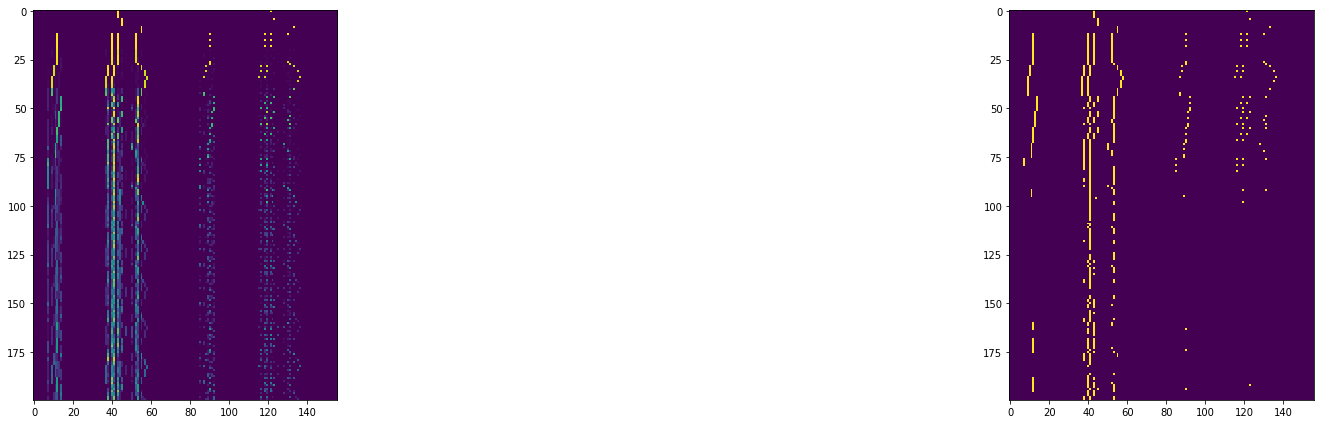

('Iter: ', 500)
('Loss: ', 87.003258)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


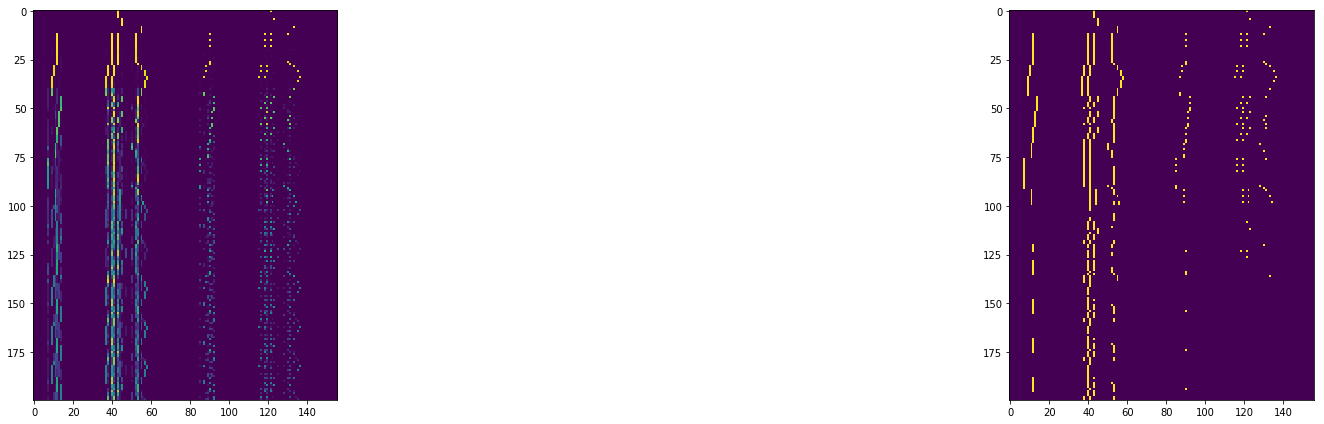

('Iter: ', 600)
('Loss: ', 77.102158)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


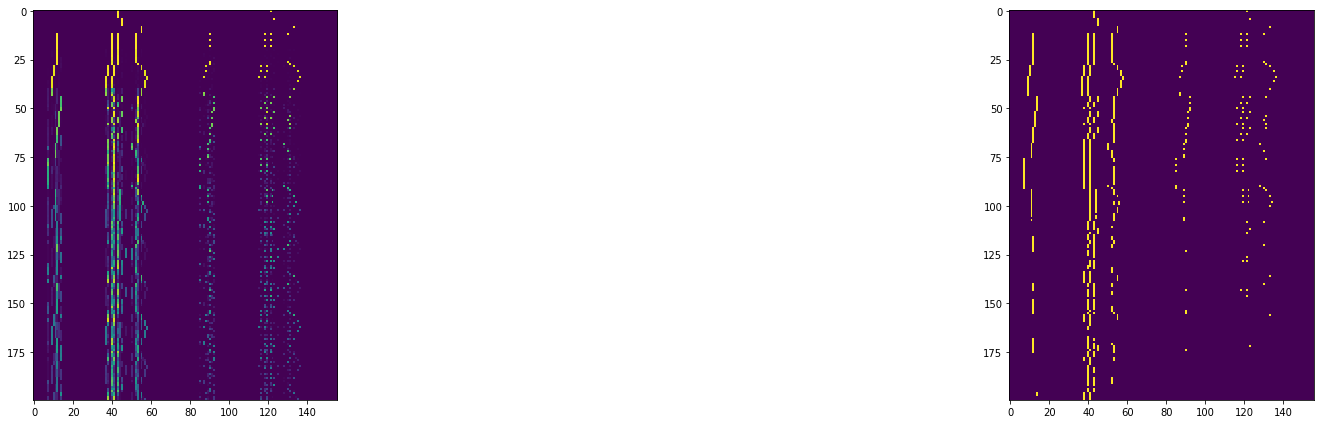

('Iter: ', 700)
('Loss: ', 69.324242)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


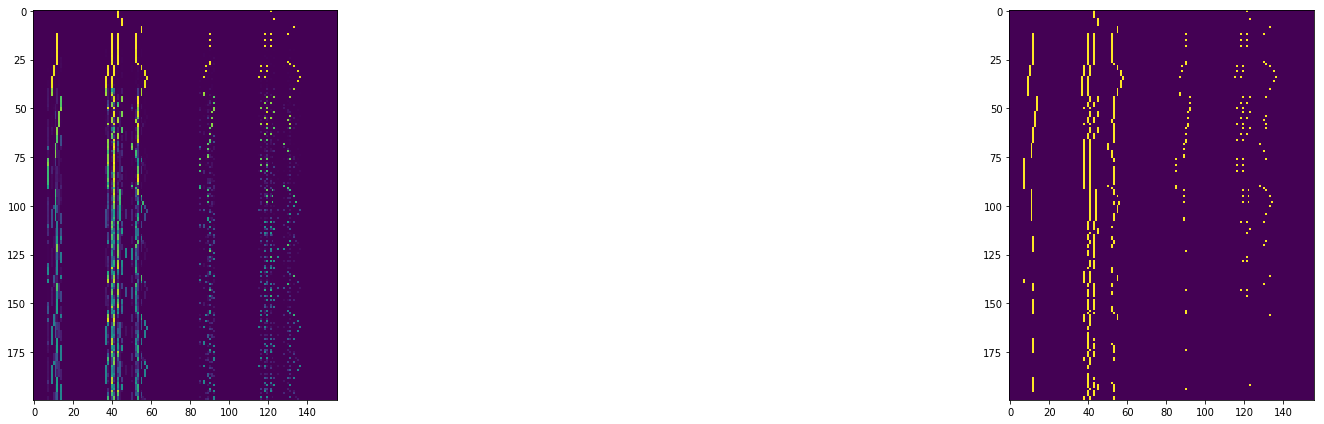

('Iter: ', 800)
('Loss: ', 63.003372)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


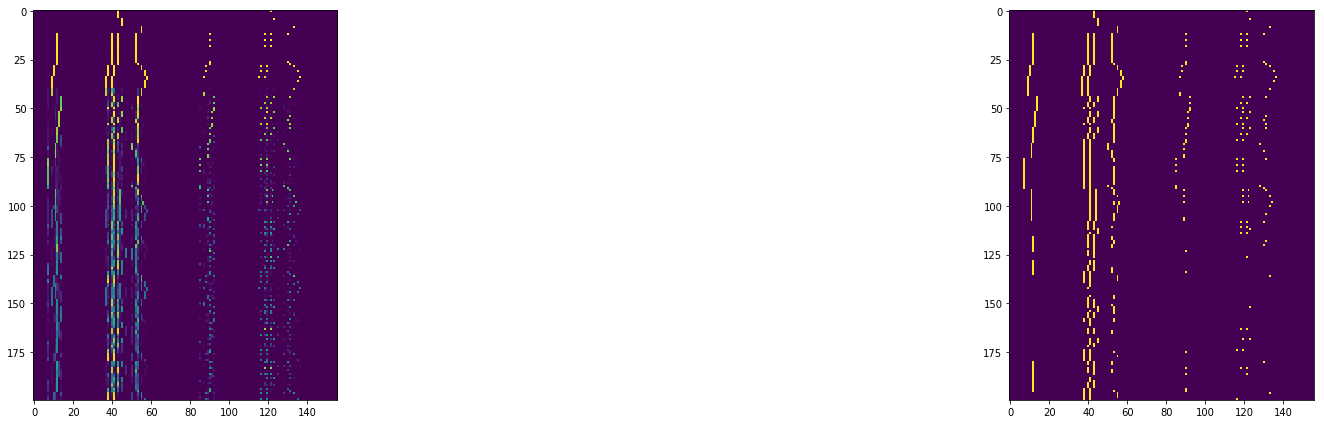

('Iter: ', 900)
('Loss: ', 57.741028)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


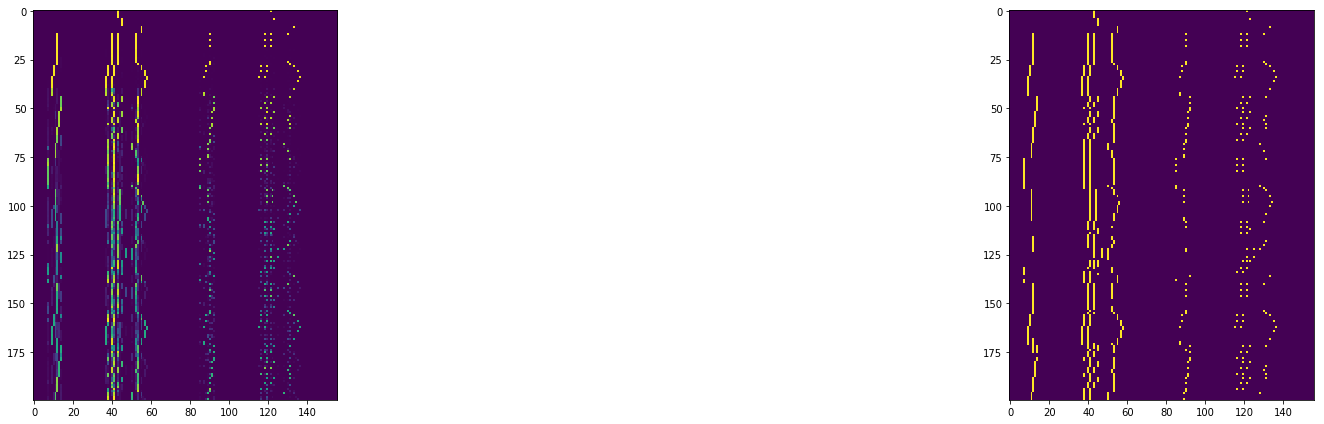

('Iter: ', 1000)
('Loss: ', 53.278915)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


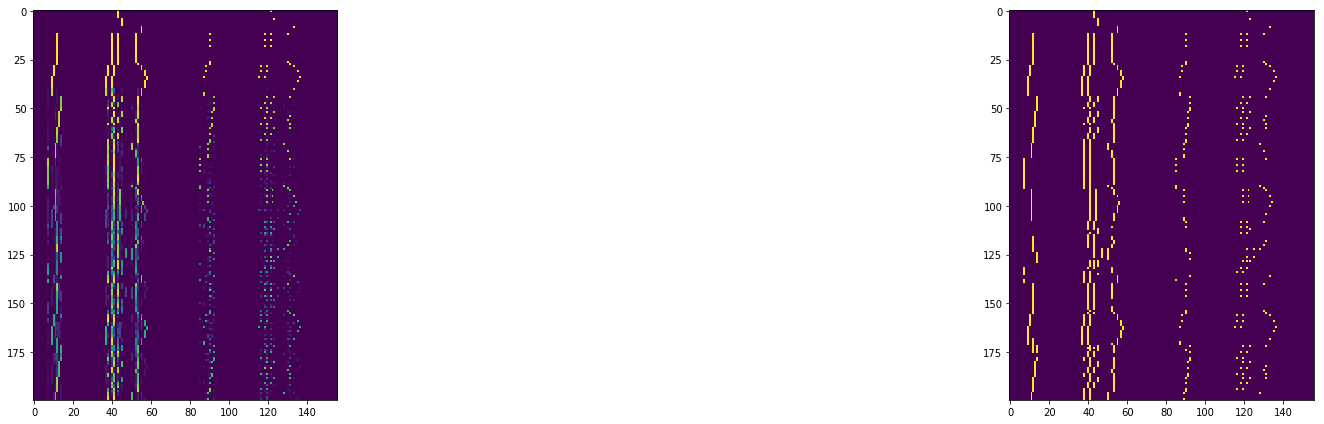

('Iter: ', 1100)
('Loss: ', 49.440243)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


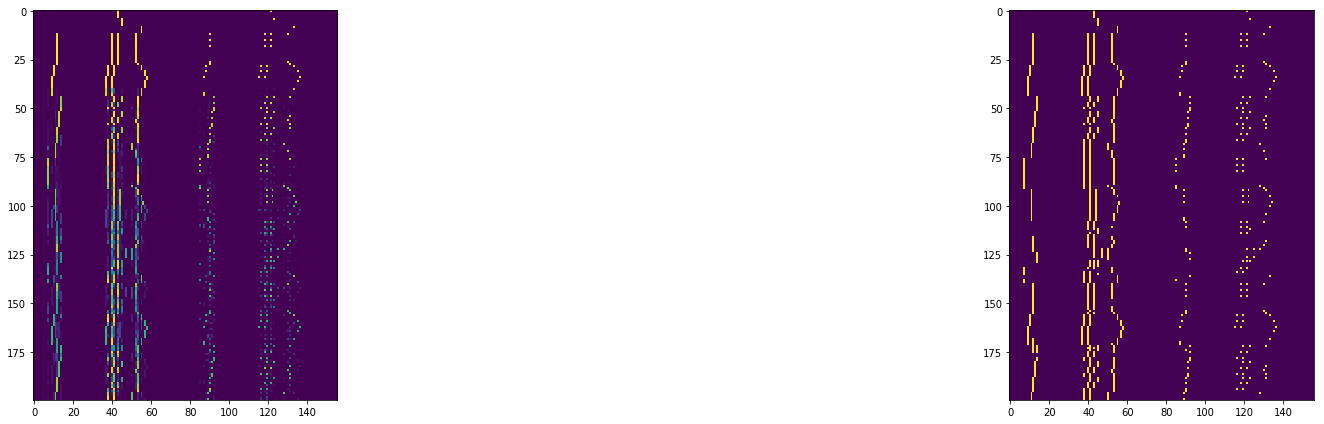

('Iter: ', 1200)
('Loss: ', 46.098976)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


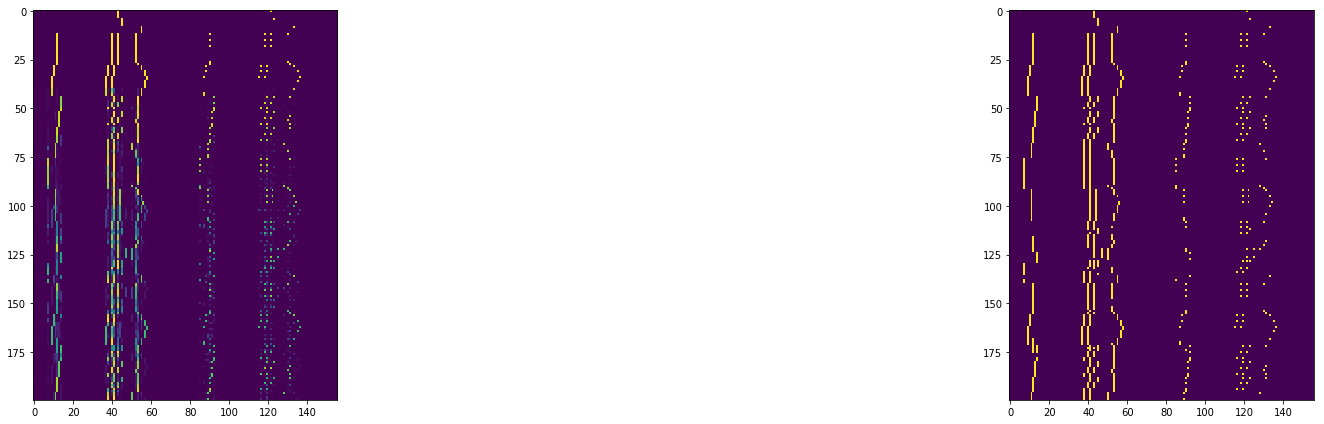

('Iter: ', 1300)
('Loss: ', 43.162304)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


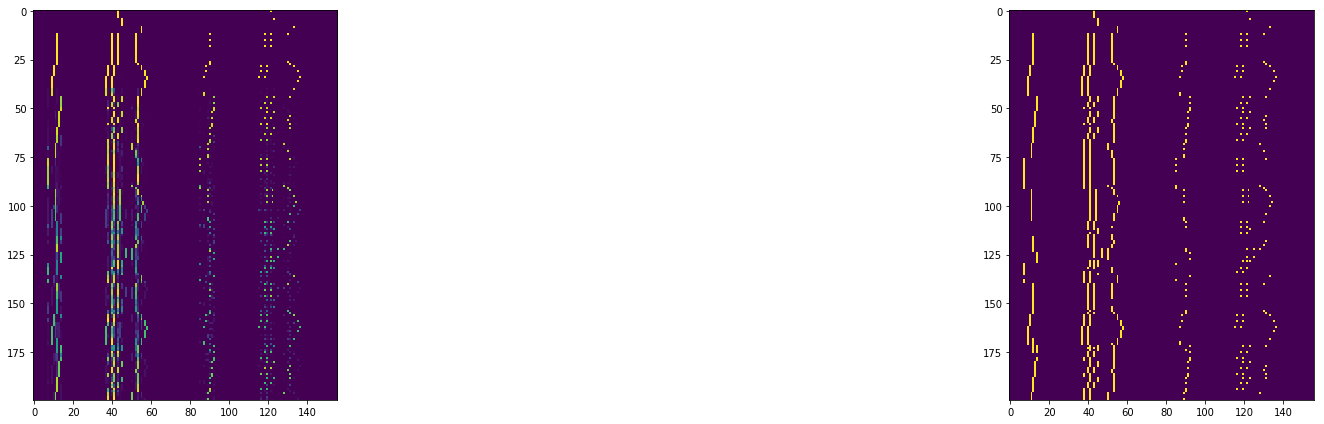

('Iter: ', 1400)
('Loss: ', 40.560051)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


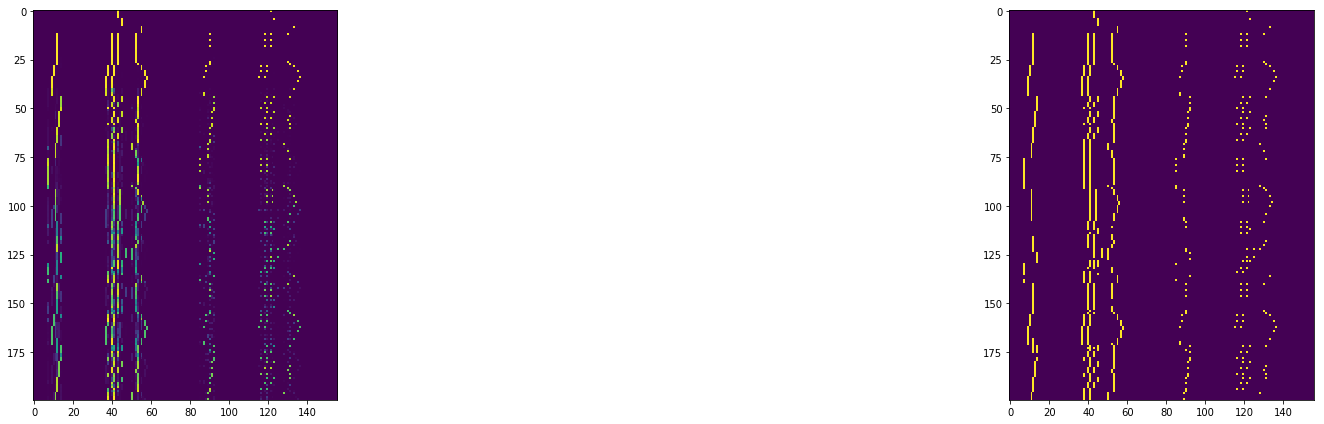

('Iter: ', 1500)
('Loss: ', 38.237995)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


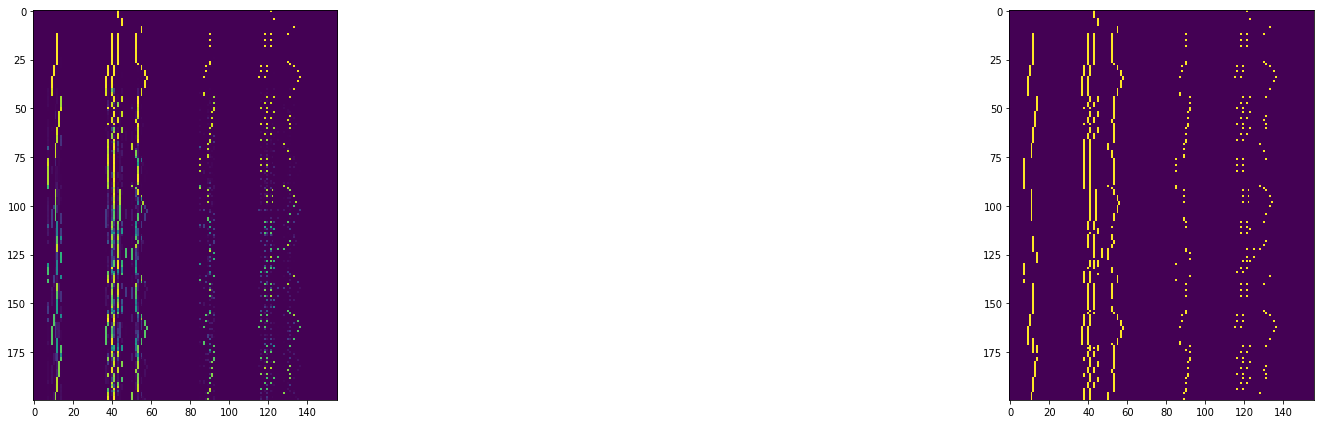

('Iter: ', 1600)
('Loss: ', 36.153439)
(1, 20, 156, 1)
(2, 20, 156, 1)
(3, 20, 156, 1)
(4, 20, 156, 1)
(5, 20, 156, 1)
(6, 20, 156, 1)
(7, 20, 156, 1)
(8, 20, 156, 1)
(9, 20, 156, 1)


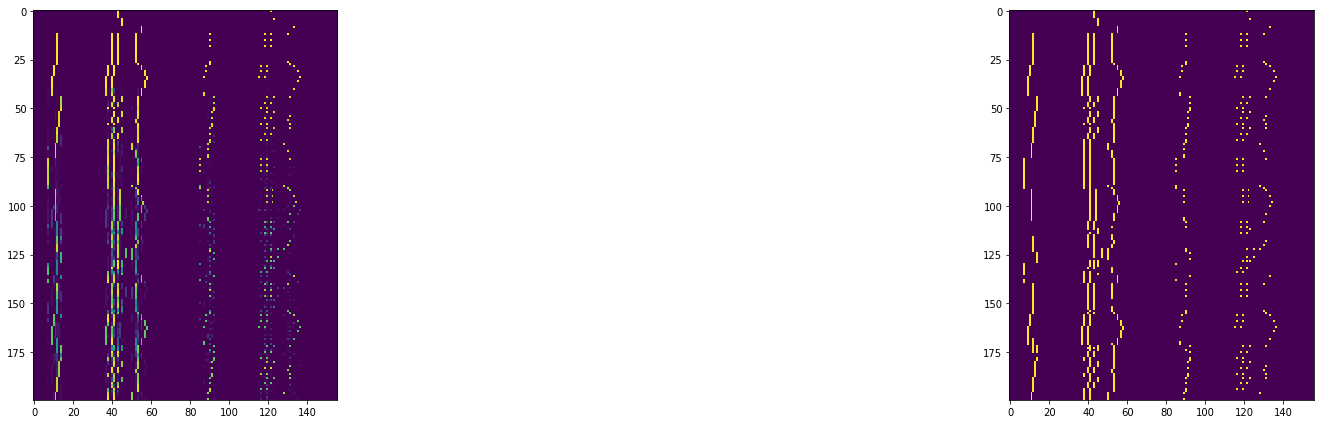

KeyboardInterrupt: 

In [9]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    while i <= num_epochs:
        #s = song[20:20+num_timesteps,:].reshape(1,num_timesteps*2*note_range)
        s = song[:num_timesteps*T,:].reshape(T, height, width, 1)
        #X_mb = song[(ind*num_timesteps):num_timesteps*(ind + 1), :].reshape(1, height, width, 1)
        _,loss_out = sess.run([solver, loss], feed_dict={X: s})

        if i % 100 == 0:
            print('Iter: ', i)
            print('Loss: ', loss_out)

            x_test = song[:num_timesteps,:].reshape(1, height, width, 1)
            for j in range(T-1):
                print(x_test.shape)
                samples_out = sess.run([samples], feed_dict={z_rnn_samples: x_test})
                frames = j + 1
                
                samples_reshape = samples_out[0].reshape((frames, height, width, 1))
                x_samples = np.concatenate([song[:num_timesteps,:].reshape(1, height, width, 1), samples_reshape], axis=0) 
                x_test = np.asarray(x_samples >= 0.5)
            
            x_samples = x_samples.reshape((num_timesteps*T, 2*note_range))
            x_test = np.asarray(x_samples >= 0.5)
            plt.figure(figsize=(36,6))
            plt.subplot(1,2,1)
            plt.imshow(x_samples)
            plt.subplot(1,2,2)
            plt.imshow(x_test)
            plt.tight_layout()
            plt.pause(0.1)
        i += 1
        saver.save(sess, "./checkpoints/rnn_sarias.ckpt")

In [16]:
with tf.Session() as sess:
    saver.restore(sess, './checkpoints/rnn_sarias.ckpt')
    #Generate T frames
    start = song[num_timesteps*11:12*(num_timesteps),:].reshape(1, height, width, 1)
    x_test = song[num_timesteps*11:12*(num_timesteps),:].reshape(1, height, width, 1)
    for j in range(T-1):
        samples_out = sess.run([samples], feed_dict={z_rnn_samples: x_test})
        frames = j + 1
        
        samples_reshape = samples_out[0].reshape((frames, height, width, 1))
        x_samples = np.concatenate([start, samples_reshape], axis=0) 
        x_test = np.asarray(x_samples >= 0.5)

samps = x_test.reshape((num_timesteps*T, 2*note_range))
thresh_S = samps>= 0.5
#song = np.concatenate((song, thresh_S), axis=0)
midi_manipulation.noteStateMatrixToMidi(thresh_S, "../audio_files/output/sonic_test")

INFO:tensorflow:Restoring parameters from ./checkpoints/rnn_sarias.ckpt
